# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un luar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro. Para ello se nos facilita un archivo  [csv](https://drive.google.com/open?id=1gTcb3WZ27DU0nMdvoyPBMYRFK8LU8-rt) donde aparecen el número de bicicletas contratadas todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de capturar la relación entre características y número de bicicletas contratadas en un modelo.


# 0. Carga de Datos

Cargaremos los datos de la misma forma que lo hemos hecho otras veces en Google Collaboratory.


In [ ]:
# 0. load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bikes.csv to bikes.csv
User uploaded file "bikes.csv" with length 54187 bytes


Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *bikes*

In [ ]:
# 0. load data in DataFrame
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), 
                    index_col = 'date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


Vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [ ]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [ ]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2011-12-31']
test  = df.loc['2012-01-01':]

display_side_by_side(train.tail(),test.head())



,temperature,humidity,windspeed,count
date,,,,
2011-12-27,9.105544,63.874550,17.145141,103.0
2011-12-28,7.820556,49.436222,24.671369,255.0
2011-12-29,5.297420,53.358888,12.220576,254.0
2011-12-30,8.443281,56.848605,13.285195,491.0
2011-12-31,6.435742,54.120804,17.410529,390.5
,temperature,humidity,windspeed,count
date,,,,
2012-01-01,4.428203,51.393004,21.535863,290.0
2012-01-02,2.420664,48.665204,25.661197,189.5


In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)


Vamos a graficar los datos de train

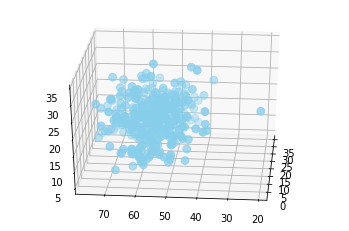

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train['temperature'], train['humidity'], train['windspeed'], c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()


#1. Parametrización

Existen diferentes parámetros que se pueden optimizar para la utilización de RandomForests,  en este caso vamos a ceñirnos a a optimizar el número de estimadores que vamos a probar con distintas potencias de 2


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
cv = TimeSeriesSplit() #

No handles with labels found to put in legend.


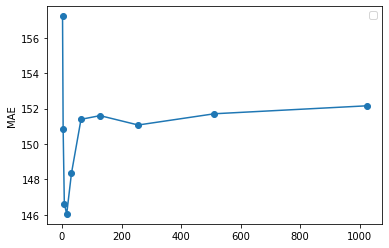

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators, 
                  criterion='mae', random_state=0)
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      regressor.fit( X = f_train.drop(['count'], axis=1), 
                           y = f_train['count'])
      y_pred = regressor.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['count'], y_pred)
      fold_accuracy.append(mae)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))


  
plt.plot(l_estimators, total_scores, marker='o')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

Min Value (estimators = 16, MAE = 146.04)


# 2. Construcción y ejecución del modelo 



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente 

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='mae', 
                                   random_state=0)
# fit and predict

regressor.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = regressor.predict(X = test.drop(['count'], axis = 1))

Calculamos el mae obtenido. Cuando se trata de una competición esta línea la ejecuta la propia competición

In [ ]:
mae = mean_absolute_error(test['count'], y_pred) 
print ('MAE', mae)

MAE 247.12926912568307


Y guardamos el fichero de resultados en nuestro disco.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': test.index, 'result': res})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


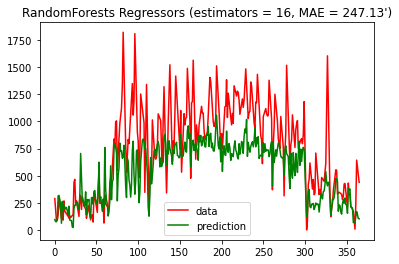

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['count'].shape[0]))
plt.plot(xx, test['count'], c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressors (estimators = %i, MAE = %6.2f')" % (best_est, mae))

plt.show()

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': ('temperature', 'humidity', 'windspeed') ,
              'Decision Tree': regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,temperature,0.671700
1,humidity,0.194211
2,windspeed,0.134089


## Boosting

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor



# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=6, criterion='mae'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=6, 
                                    criterion='mae'),
                          n_estimators=128, random_state=0))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=50, learning_rate=0.25, 
                                            random_state=0, loss='ls'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


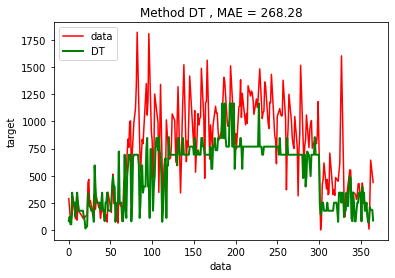

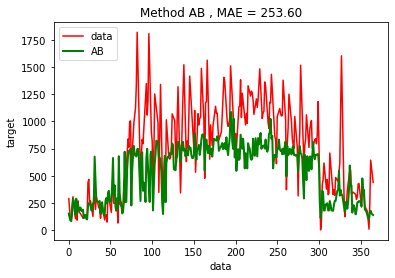

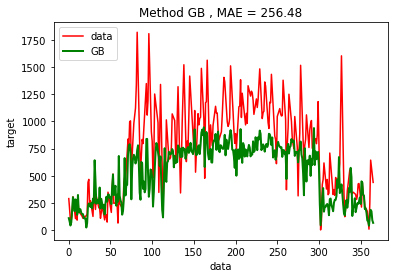

In [ ]:
xx = np.stack(i for i in range(len(test['count'])))
regr_names = ["DT", "AB", "GB"]

results = pd.DataFrame()
results['real'] = test['count']
               
for i, r in enumerate(regressors):
    r.fit( X = train.drop(['count'], axis=1), y = train['count'])
    y = r.predict(X = test.drop(['count'], axis = 1))
    results[regr_names[i]] = y
    mae = mean_absolute_error(test['count'],y)
    # Plot the results
    plt.figure()
    plt.plot(xx, test['count'], c='r', label='data')
    plt.plot(xx, y, c="g", label=regr_names[i], linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Method %s , MAE = %6.2f" % (regr_names[i], mae ))
    plt.axis('tight')
    plt.legend()
    plt.show()

In [ ]:
from google.colab import files

with open('results.xlsx', 'w') as f:
  results.to_excel(f,  index = False)
  

files.download('results.xlsx')